#**Business Objective:**

Need to get sentiment analysis of financial statements and gauge its impact i.e. positive, negative or neutral on the business and government.

# **Raw Data**

In [ ]:
#Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk, re, string
from string import punctuation
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [ ]:
# Read the financial statements data into a pandas DataFrame
df = pd.read_csv(r'/content/financial_sentiment_data.csv')
df.head()

Sentence Sentiment
0  The GeoSolutions technology will leverage Bene...  positive
1  $ESI on lows, down $1.50 to $2.50 BK a real po...  negative
2  For the last quarter of 2010 , Componenta 's n...  positive
3  According to the Finnish-Russian Chamber of Co...   neutral
4  The Swedish buyout firm has sold its remaining...   neutral

In [ ]:
#data describe
df.describe()

Sentence Sentiment
count                                                5842      5842
unique                                               5322         3
top     Managing Director 's comments : `` Net sales f...   neutral
freq                                                    2      3130

In [ ]:
#data information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5842 entries, 0 to 5841
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentence   5842 non-null   object
 1   Sentiment  5842 non-null   object
dtypes: object(2)
memory usage: 91.4+ KB


In [ ]:
#Data Shape
df.shape

(5842, 2)

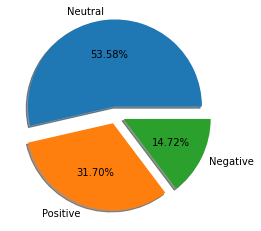

In [ ]:
#Data Visualise in Pie chart

plt.pie(df.Sentiment.value_counts()/len(df), #(neutral=3130, positive = 1852, negative = 860)/5842
        labels =['Neutral','Positive','Negative'],
        autopct='%1.2f%%',shadow=True,explode=(0.1, 0.1,0.1)) 
# autopct is for displaying the percentage. here it is for 2 decimal
# explode for the gap 

plt.show()

<AxesSubplot:xlabel='Sentiment', ylabel='count'>

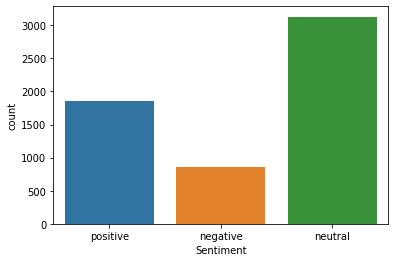

In [ ]:
#Data Visualise in Bar chart

sns.countplot(x='Sentiment',data=df)

Detecting Languages

---

Here we are detecting the languages for the dataset

In [ ]:
pip install langdetect

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 KB 42.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993242 sha256=829fd564fa26f7bf9032ee014f5fb2e274895930cf443dff310e4e7ef1fa4e70
  Stored in directory: /root/.cache/pip/wheels/d1/c1/d9/7e068de779d863bc8f8fc9467d85e25cfe47fa5051fff1a1bb
Successfully built langdetect


In [ ]:
from langdetect import detect_langs

sentence = list(df.Sentence)
languages = []

for i in range(len(sentence)):
    languages.append(detect_langs(sentence[i]))
    
print('The detected languages are: ', languages[:3])

The detected languages are:  [[en:0.9999961945731998], [en:0.9999957376395688], [en:0.9999971045200502]]


In [ ]:
languages = [str(lang).split(':')[0][1:] for lang in languages] #converting the lang to string.splitting with this and calling the first element
df['language'] = languages
display(df.language.describe())
display(df['language'].value_counts())
display(df.head())

count     5842
unique      17
top         en
freq      5744
Name: language, dtype: object

en    5744
tl      16
ca      14
de      13
fr      10
it       8
da       8
nl       6
af       5
no       5
sv       4
so       3
et       2
vi       1
pt       1
es       1
cy       1
Name: language, dtype: int64

Sentence Sentiment language
0  The GeoSolutions technology will leverage Bene...  positive       en
1  $ESI on lows, down $1.50 to $2.50 BK a real po...  negative       en
2  For the last quarter of 2010 , Componenta 's n...  positive       en
3  According to the Finnish-Russian Chamber of Co...   neutral       en
4  The Swedish buyout firm has sold its remaining...   neutral       en

From the above we obsereved that majority of the language is of english.

# **Data Cleaning**

In [ ]:
def text_normalization(text):
    #1) converting all characters to lower case
    text = text.lower()
    #2) removing punctuations
    punc = str.maketrans(string.punctuation, ' '*len(string.punctuation))
    text = text.translate(punc)
    #2) removing extra white spaces
    text = re.sub('\s+', ' ', text).strip()
    #4) removing special characters
    text = re.sub('[^A-Za-z0-9\s]+', '', text)
    #5) removing numbers
    text = re.sub('\d+', '', text)
    ###5) removing punctuations
    ###text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    #6) removing links
    text = re.sub('https?://\S+|www\.\S+', '', text)
    #7) Deleting newlines
    text = re.sub('\n', '', text)
    return text       

In [ ]:
df['Sentence'] = df['Sentence'].apply(text_normalization)

In [ ]:
df.head()

Sentence Sentiment language
0  the geosolutions technology will leverage bene...  positive       en
1      esi on lows down   to   bk a real possibility  negative       en
2  for the last quarter of  componenta s net sale...  positive       en
3  according to the finnish russian chamber of co...   neutral       en
4  the swedish buyout firm has sold its remaining...   neutral       en

Lemmatiztion and removal of Stop Words.

In [ ]:
#import libraries
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
#lemmatize the words.
lemmatizer = WordNetLemmatizer()
Stopwords = set(nltk.corpus.stopwords.words("english")) - set(["not"])

In [ ]:
def preprocess_text(text):
    text = text.lower()
    tokens = nltk.word_tokenize(text)
    tokens = [token for token in tokens if token not in Stopwords ]
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    text = " ".join(tokens)
    return text

In [ ]:
df["Sentence"] = df['Sentence'].apply(preprocess_text)

In [ ]:
df.head()

Sentence Sentiment language
0  geosolutions technology leverage benefon gps s...  positive       en
1                        esi low bk real possibility  negative       en
2  last quarter componenta net sale doubled eurm ...  positive       en
3  according finnish russian chamber commerce maj...   neutral       en
4  swedish buyout firm sold remaining percent sta...   neutral       en

In [ ]:
df.to_csv('financial_data_cleaned.csv', index=False)

In [ ]:
df = df.drop("language", axis = 1)

In [ ]:
df.head()

Sentence Sentiment
0  geosolutions technology leverage benefon gps s...  positive
1                        esi low bk real possibility  negative
2  last quarter componenta net sale doubled eurm ...  positive
3  according finnish russian chamber commerce maj...   neutral
4  swedish buyout firm sold remaining percent sta...   neutral

In [ ]:
#Seperating the Sentences based on sentiment

df_pos = df[df['Sentiment']=='positive']
df_neu = df[df["Sentiment"]=="neutral"]
df_neg = df[df['Sentiment']=='negative']

#**Positive Sentiment**

In [ ]:
print(df_pos)

                                               Sentence Sentiment
0     geosolutions technology leverage benefon gps s...  positive
2     last quarter componenta net sale doubled eurm ...  positive
5                         spy surprised see green close  positive
8         kone net sale rose year year first nine month  positive
10         circulation revenue increased finland sweden  positive
...                                                 ...       ...
5819  last month added gild position started new one...  positive
5824  newly formed company yit stavo local contact n...  positive
5825  friend life lift profit hike divi ahead propos...  positive
5836  daily mail parent company talk potential partn...  positive
5841  helsinki afx kci konecranes said order four ho...  positive

[1852 rows x 2 columns]


In [ ]:
tokenized_text_pos = ' '.join(df_pos['Sentence']).split()
print(tokenized_text_pos)

['geosolutions', 'technology', 'leverage', 'benefon', 'gps', 'solution', 'providing', 'location', 'based', 'search', 'technology', 'community', 'platform', 'location', 'relevant', 'multimedia', 'content', 'new', 'powerful', 'commercial', 'model', 'last', 'quarter', 'componenta', 'net', 'sale', 'doubled', 'eurm', 'eurm', 'period', 'year', 'earlier', 'moved', 'zero', 'pre', 'tax', 'profit', 'pre', 'tax', 'loss', 'eurm', 'spy', 'surprised', 'see', 'green', 'close', 'kone', 'net', 'sale', 'rose', 'year', 'year', 'first', 'nine', 'month', 'circulation', 'revenue', 'increased', 'finland', 'sweden', 'subdivision', 'made', 'sale', 'revenue', 'last', 'year', 'eur', 'million', 'eur', 'million', 'operating', 'profit', 'eur', 'million', 'eur', 'million', 'fb', 'gone', 'green', 'day', 'msft', 'sql', 'server', 'revenue', 'grew', 'double', 'digit', 'sql', 'server', 'premium', 'revenue', 'growing', 'http', 'stks', 'co', 'irf', 'aviva', 'friend', 'life', 'top', 'forecast', 'ahead', 'billion', 'pound', 

counter = it will return a dictionary-like object elements in the list and the values are the number of times each element appears in the list.

printing the most common 75 positive words

In [ ]:
from collections import Counter
word_counts_pos = Counter(tokenized_text_pos)

**For Positive Sentiment**


In [ ]:
import itertools

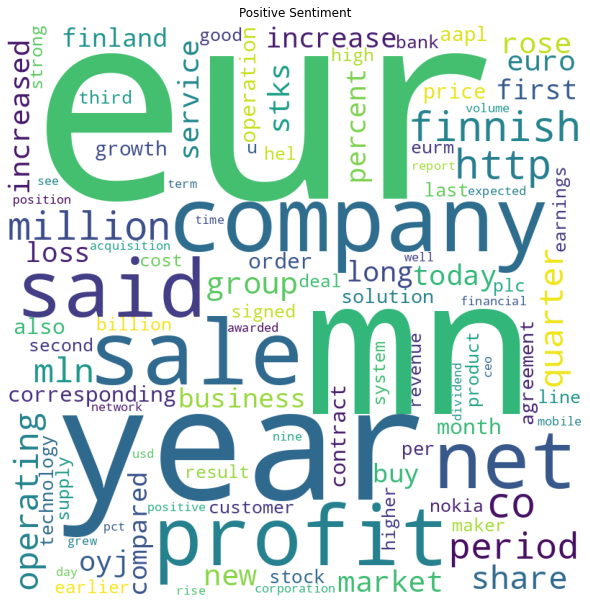

In [ ]:
#Word cloud for Positive Sentiment
wordcloud = WordCloud(width=800, height=800, background_color='white', max_words=100).generate_from_frequencies(word_counts_pos)
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.title('Positive Sentiment')
plt.show()

In [ ]:
#Most common words in Positive Sentiment
print(word_counts_pos.most_common(75))

[('eur', 584), ('mn', 259), ('year', 236), ('company', 232), ('sale', 229), ('profit', 209), ('net', 197), ('said', 194), ('finnish', 181), ('co', 180), ('http', 174), ('million', 164), ('period', 141), ('mln', 125), ('quarter', 124), ('operating', 120), ('share', 114), ('group', 105), ('new', 96), ('market', 94), ('rose', 92), ('stks', 92), ('increased', 89), ('service', 89), ('euro', 87), ('long', 84), ('oyj', 83), ('today', 82), ('loss', 76), ('first', 76), ('increase', 76), ('percent', 74), ('business', 72), ('buy', 70), ('compared', 70), ('finland', 67), ('corresponding', 64), ('also', 63), ('month', 62), ('order', 61), ('operation', 59), ('contract', 59), ('price', 57), ('growth', 55), ('aapl', 55), ('agreement', 53), ('solution', 52), ('technology', 49), ('last', 48), ('per', 48), ('stock', 48), ('earnings', 44), ('signed', 44), ('product', 43), ('customer', 42), ('hel', 42), ('high', 41), ('cost', 40), ('higher', 40), ('plc', 40), ('u', 39), ('good', 39), ('deal', 39), ('eurm',

In [ ]:
print(type(word_counts_pos))

<class 'collections.Counter'>


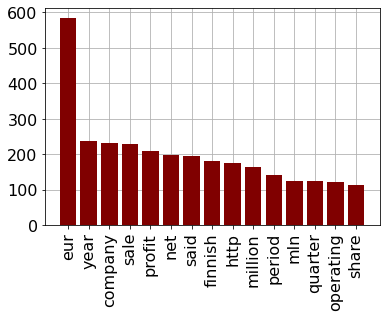

In [ ]:
#bar graphs as per word and word count for Positive Sentiment 

tokens_pos = [word_tokenize(review) for review in tokenized_text_pos]
pos_tokens = [[word for word in item if len(word) > 2] for item in tokens_pos]
last_token = list(itertools.chain(*pos_tokens)) 
bow_pos = Counter(last_token).most_common(15) ### Displays the 15 most common words in pos articles of the dataset.
labels = [item[0] for item in bow_pos]
number = [item[1] for item in bow_pos]
nbars = len(bow_pos)

plt.grid(zorder=0)
plt.bar(np.arange(nbars), number, tick_label=labels,color ='maroon',zorder=3)
plt.xticks(rotation=90,fontsize=16)
plt.yticks(fontsize=16)
plt.show()

# **For Neutral Sentiment**

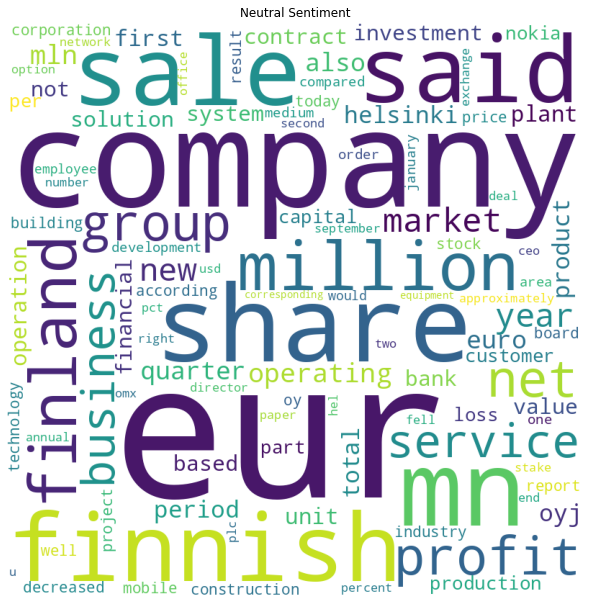

In [ ]:
#Word cloud for Neutral Sentiment
df_neu = df[df["Sentiment"]=="neutral"]
tokenized_text_neu = ' '.join(df_neu['Sentence']).split()
word_counts_neu = Counter(tokenized_text_neu)
wordcloud = WordCloud(width=800, height=800, background_color='white', max_words=100).generate_from_frequencies(word_counts_neu)
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.title('Neutral Sentiment')
plt.show()

In [ ]:
#Most common words in Neutral Sentiment
word_counts_neu = Counter(tokenized_text_neu)
print(word_counts_neu.most_common(75))

[('eur', 672), ('company', 596), ('share', 332), ('mn', 329), ('sale', 271), ('finnish', 267), ('said', 258), ('million', 251), ('finland', 236), ('profit', 216), ('net', 203), ('group', 202), ('service', 197), ('business', 190), ('market', 188), ('year', 188), ('new', 172), ('operating', 162), ('mln', 158), ('euro', 139), ('quarter', 136), ('also', 134), ('total', 119), ('oyj', 119), ('product', 117), ('helsinki', 117), ('period', 115), ('first', 109), ('unit', 102), ('plant', 102), ('operation', 100), ('investment', 95), ('not', 95), ('solution', 94), ('bank', 93), ('financial', 91), ('contract', 89), ('based', 89), ('value', 88), ('system', 87), ('production', 86), ('capital', 85), ('nokia', 83), ('per', 82), ('loss', 82), ('customer', 81), ('part', 81), ('corporation', 80), ('today', 80), ('project', 79), ('price', 79), ('board', 79), ('according', 77), ('stock', 77), ('mobile', 76), ('building', 75), ('report', 74), ('well', 74), ('result', 71), ('oy', 70), ('construction', 69), (

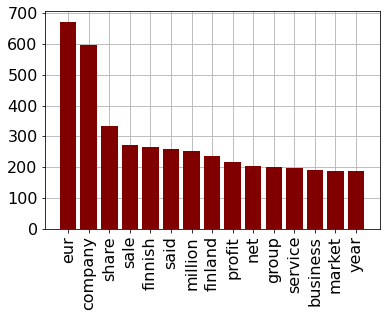

In [ ]:
#bar graphs as per word and word count for Neutral Sentiment

tokens_neu = [word_tokenize(review) for review in tokenized_text_neu]
neu_tokens = [[word for word in item if len(word) > 2] for item in tokens_neu]
last_token = list(itertools.chain(*neu_tokens)) 
bow_neu = Counter(last_token).most_common(15) ### Displays the 15 most common words in neu articles of the dataset.
labels = [item[0] for item in bow_neu]
number = [item[1] for item in bow_neu]
nbars = len(bow_neu)

plt.grid(zorder=0)
plt.bar(np.arange(nbars), number, tick_label=labels,color ='maroon',zorder=3)
plt.xticks(rotation=90,fontsize=16)
plt.yticks(fontsize=16)
plt.show()

# **For Negative Sentiment**

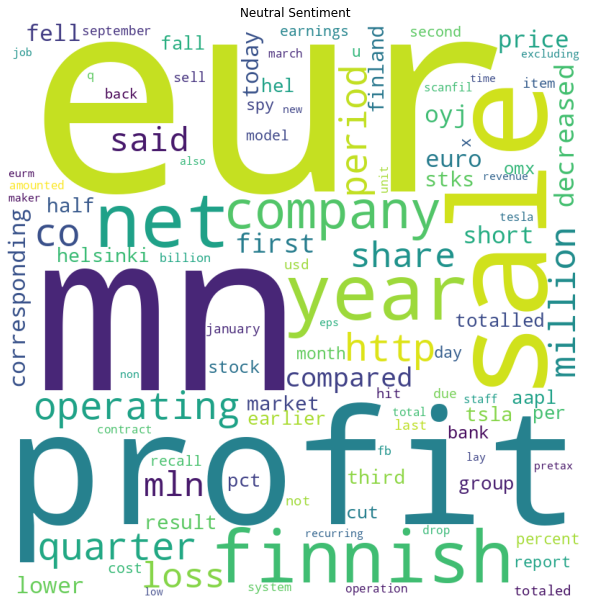

In [ ]:
#Word cloud for Negative Sentiment
df_neu = df[df["Sentiment"]=="negative"]
tokenized_text_neg = ' '.join(df_neg['Sentence']).split()
word_counts_neg = Counter(tokenized_text_neg)
wordcloud = WordCloud(width=800, height=800, background_color='white', max_words=100).generate_from_frequencies(word_counts_neg)
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.title('Neutral Sentiment')
plt.show()

In [ ]:
#Most common words in Negative Sentiment
word_counts_neg = Counter(tokenized_text_neg)
print(word_counts_neg.most_common(75))

[('eur', 376), ('mn', 233), ('profit', 160), ('sale', 109), ('year', 104), ('net', 100), ('finnish', 91), ('company', 89), ('operating', 89), ('http', 88), ('co', 88), ('quarter', 88), ('period', 82), ('million', 79), ('loss', 76), ('share', 75), ('mln', 68), ('said', 64), ('compared', 62), ('decreased', 61), ('first', 60), ('euro', 48), ('oyj', 48), ('short', 47), ('price', 46), ('fell', 44), ('corresponding', 44), ('lower', 43), ('today', 40), ('stks', 36), ('finland', 36), ('result', 34), ('tsla', 34), ('market', 34), ('half', 33), ('helsinki', 31), ('third', 31), ('pct', 29), ('group', 29), ('fall', 28), ('earlier', 28), ('aapl', 27), ('per', 27), ('totalled', 26), ('hel', 26), ('cut', 24), ('stock', 23), ('omx', 23), ('bank', 23), ('month', 22), ('x', 21), ('spy', 21), ('day', 21), ('report', 21), ('u', 20), ('percent', 20), ('model', 19), ('recall', 19), ('cost', 19), ('second', 19), ('earnings', 19), ('hit', 18), ('usd', 18), ('totaled', 18), ('back', 18), ('not', 18), ('last', 

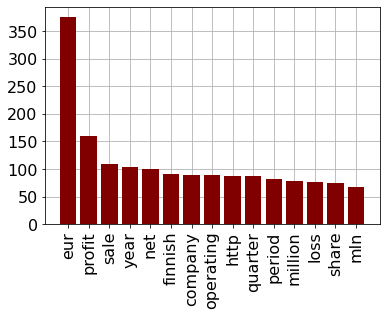

In [ ]:
#bar graphs as per word and word count for Negative Sentiment

tokens_neg = [word_tokenize(review) for review in tokenized_text_neg]
neg_tokens = [[word for word in item if len(word) > 2] for item in tokens_neg]
last_token = list(itertools.chain(*neg_tokens)) 
bow_neg = Counter(last_token).most_common(15) ### Displays the 15 most common words in neg articles of the dataset.
labels = [item[0] for item in bow_neg]
number = [item[1] for item in bow_neg]
nbars = len(bow_neg)

plt.grid(zorder=0)
plt.bar(np.arange(nbars), number, tick_label=labels,color ='maroon',zorder=3)
plt.xticks(rotation=90,fontsize=16)
plt.yticks(fontsize=16)
plt.show()

# **For All Sentiments**

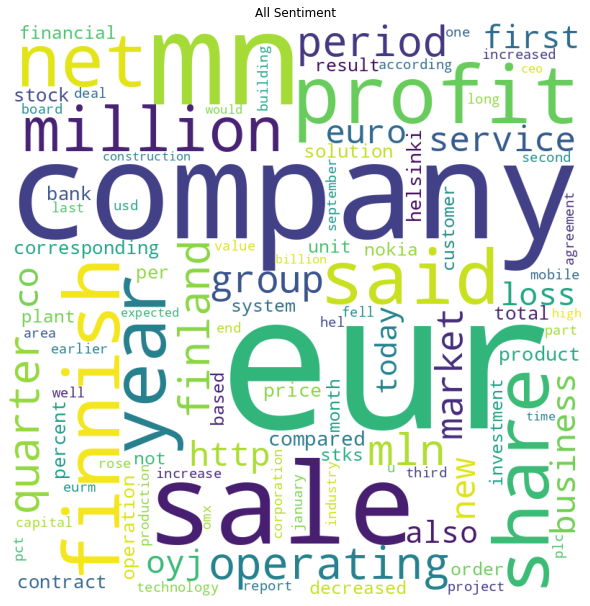

In [ ]:
#Word cloud for All Sentiments
df_all = df["Sentence"]
tokenized_text_all = ' '.join(df_all).split()
word_counts_all = Counter(tokenized_text_all)
wordcloud = WordCloud(width=800, height=800, background_color='white', max_words=100).generate_from_frequencies(word_counts_all)
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.title('All Sentiment')
plt.show()

In [ ]:
#Most common words in All Sentiment
word_counts_neg = Counter(tokenized_text_all)
print(word_counts_all.most_common(75))

[('eur', 1632), ('company', 917), ('mn', 821), ('sale', 609), ('profit', 585), ('finnish', 539), ('year', 528), ('share', 521), ('said', 516), ('net', 500), ('million', 494), ('operating', 371), ('mln', 351), ('quarter', 348), ('finland', 339), ('period', 338), ('group', 336), ('market', 316), ('co', 296), ('service', 290), ('new', 282), ('euro', 274), ('http', 271), ('business', 271), ('oyj', 250), ('first', 245), ('loss', 234), ('also', 211), ('today', 202), ('compared', 199), ('price', 182), ('helsinki', 176), ('operation', 174), ('product', 172), ('contract', 163), ('corresponding', 158), ('per', 157), ('solution', 155), ('bank', 152), ('total', 151), ('percent', 150), ('stock', 148), ('result', 142), ('system', 141), ('unit', 140), ('plant', 137), ('order', 135), ('financial', 135), ('stks', 132), ('not', 132), ('month', 131), ('decreased', 131), ('investment', 129), ('based', 127), ('customer', 127), ('nokia', 127), ('technology', 125), ('report', 125), ('hel', 124), ('corporatio

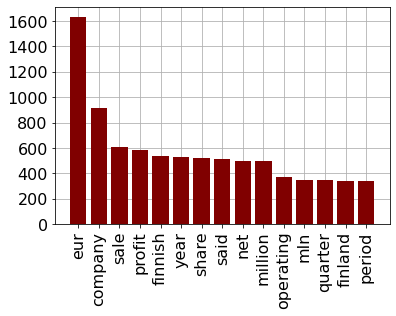

In [ ]:
#bar graphs as per word and word count for all sentiments
tokens_all = [word_tokenize(review) for review in tokenized_text_all]
all_tokens = [[word for word in item if len(word) > 2] for item in tokens_all]
last_token = list(itertools.chain(*all_tokens)) 
bow_all = Counter(last_token).most_common(15) ### Displays the 15 most common words in all articles of the dataset.
labels = [item[0] for item in bow_all]
number = [item[1] for item in bow_all]
nbars = len(bow_all)
plt.grid(zorder=0)
plt.bar(np.arange(nbars), number, tick_label=labels,color ='maroon',zorder=3)
plt.xticks(rotation=90,fontsize=16)
plt.yticks(fontsize=16)
plt.show()


Printing of all tokenized text of types of sentiments

In [ ]:
#Tokenized text of types of Sentiments
#Tokenized text of types of Positive Sentiments
#Tokenized text of types of Negative Sentiments
#Tokenized text of types of Neutral Sentiments

print('Tokenized text of types of sentiments', tokenized_text_all)
print('Tokenized text of types of sentiments', tokenized_text_pos)
print('Tokenized text of types of sentiments', tokenized_text_neg)
print('Tokenized text of types of sentiments', tokenized_text_neu)

Tokenized text of types of sentiments ['geosolutions', 'technology', 'leverage', 'benefon', 'gps', 'solution', 'providing', 'location', 'based', 'search', 'technology', 'community', 'platform', 'location', 'relevant', 'multimedia', 'content', 'new', 'powerful', 'commercial', 'model', 'esi', 'low', 'bk', 'real', 'possibility', 'last', 'quarter', 'componenta', 'net', 'sale', 'doubled', 'eurm', 'eurm', 'period', 'year', 'earlier', 'moved', 'zero', 'pre', 'tax', 'profit', 'pre', 'tax', 'loss', 'eurm', 'according', 'finnish', 'russian', 'chamber', 'commerce', 'major', 'construction', 'company', 'finland', 'operating', 'russia', 'swedish', 'buyout', 'firm', 'sold', 'remaining', 'percent', 'stake', 'almost', 'eighteen', 'month', 'taking', 'company', 'public', 'finland', 'spy', 'surprised', 'see', 'green', 'close', 'shell', 'billion', 'bg', 'deal', 'meet', 'shareholder', 'skepticism', 'ssh', 'communication', 'security', 'corp', 'stock', 'exchange', 'release', 'october', 'pm', 'company', 'updat

To remove the top 75 words which are common in positive, negative, neutral

Caluclating for all the common words

In [ ]:
#Here we get ouput type is set

#finding the common words in the entire list
duplicates = set(x for x in tokenized_text_all if tokenized_text_all.count(x)>1)
#print(duplicates)
#finding the common words which are present in all types of  sentiments
common_duplicates = set(x for x in duplicates if x in tokenized_text_pos and x in tokenized_text_neg and x in tokenized_text_neu)
len(common_duplicates)

1349

In [ ]:
print(common_duplicates)

{'carrier', 'guidance', 'claim', 'initial', 'heating', 'smaller', 'world', 'swung', 'achieve', 'side', 'april', 'follow', 'housing', 'revenue', 'tietoenator', 'unless', 'coming', 'building', 'oy', 'neste', 'travel', 'sheet', 'bottom', 'electronics', 'administration', 'small', 'irish', 'resistance', 'cargo', 'firm', 'commercial', 'took', 'island', 'back', 'issue', 'local', 'kone', 'not', 'decision', 'residential', 'falling', 'ground', 'came', 'ilkka', 'effect', 'pt', 'ibm', 'eb', 'therefore', 'team', 'lse', 'add', 'producer', 'repeat', 'gone', 'action', 'bn', 'cruise', 'microsoft', 'job', 'incap', 'lvl', 'ag', 'tool', 'search', 'sto', 'refining', 'ups', 'capital', 'move', 'first', 'insurance', 'meeting', 'passenger', 'apart', 'competition', 'top', 'leave', 'agency', 'demand', 'communication', 'chart', 'marimekko', 'march', 'er', 'www', 'penny', 'efore', 'buying', 'rally', 'winter', 'retail', 'gift', 'free', 'mobile', 'norway', 'model', 'consumer', 'goog', 'ramirent', 'water', 'generated

In [ ]:
# here we get output type is list

# finding unique items for postive sentiment
tokenized_text_pos
unique_items_pos = []
for item in tokenized_text_pos:
    if item not in unique_items_pos:
        unique_items_pos.append(item)
print(unique_items_pos)
# finding unique items for negative sentiment
tokenized_text_neg
unique_items_neg = []
for item in tokenized_text_neg:
    if item not in unique_items_neg:
        unique_items_neg.append(item)
print(unique_items_neg)
# finding unique items for neutral sentiment
tokenized_text_neu
unique_items_neu = []
for item in tokenized_text_neu:
    if item not in unique_items_neu:
        unique_items_neu.append(item)
print(unique_items_neu)
# the words which are common in the neutral, negative, sentiment
common_words = []
for word in unique_items_pos:
    if word in unique_items_neg and word in unique_items_neu:
        common_words.append(word)

['geosolutions', 'technology', 'leverage', 'benefon', 'gps', 'solution', 'providing', 'location', 'based', 'search', 'community', 'platform', 'relevant', 'multimedia', 'content', 'new', 'powerful', 'commercial', 'model', 'last', 'quarter', 'componenta', 'net', 'sale', 'doubled', 'eurm', 'period', 'year', 'earlier', 'moved', 'zero', 'pre', 'tax', 'profit', 'loss', 'spy', 'surprised', 'see', 'green', 'close', 'kone', 'rose', 'first', 'nine', 'month', 'circulation', 'revenue', 'increased', 'finland', 'sweden', 'subdivision', 'made', 'eur', 'million', 'operating', 'fb', 'gone', 'day', 'msft', 'sql', 'server', 'grew', 'double', 'digit', 'premium', 'growing', 'http', 'stks', 'co', 'irf', 'aviva', 'friend', 'life', 'top', 'forecast', 'ahead', 'billion', 'pound', 'merger', 'shire', 'ceo', 'step', 'drive', 'get', 'baxalta', 'board', 'talking', 'costco', 'premier', 'retail', 'dividend', 'play', 'facnhtt', 'cost', 'stockmann', 'swedish', 'sector', 'company', 'ab', 'lindex', 'entered', 'agreement'

In [ ]:
print(len(common_words))
print(type(common_words))

1349
<class 'list'>


In [ ]:
print(common_words)

['technology', 'gps', 'solution', 'providing', 'based', 'search', 'new', 'commercial', 'model', 'last', 'quarter', 'componenta', 'net', 'sale', 'eurm', 'period', 'year', 'earlier', 'moved', 'pre', 'tax', 'profit', 'loss', 'see', 'green', 'close', 'kone', 'rose', 'first', 'nine', 'month', 'revenue', 'increased', 'finland', 'sweden', 'made', 'eur', 'million', 'operating', 'fb', 'gone', 'day', 'double', 'http', 'stks', 'co', 'aviva', 'life', 'top', 'forecast', 'ahead', 'billion', 'pound', 'merger', 'ceo', 'step', 'get', 'board', 'retail', 'dividend', 'play', 'cost', 'stockmann', 'swedish', 'sector', 'company', 'ab', 'agreement', 'september', 'wholly', 'owned', 'subsidiary', 'make', 'public', 'issued', 'share', 'cramo', 'group', 'royal', 'dutch', 'shell', 'buy', 'bg', 'nearly', 'item', 'included', 'restructuring', 'diluted', 'eps', 'stood', 'versus', 'per', 'according', 'finnish', 'pension', 'insurance', 'two', 'third', 'earnings', 'related', 'cover', 'competitive', 'recorded', 'part', 'pa

In [ ]:
print("for words is", type(common_words))
print("for duplicate is",type(common_duplicates))

for words is <class 'list'>
for duplicate is <class 'set'>


To convert collections.counter we need to convert it to dictonaries and then data frame for removal of top 75 words

In [ ]:
word_counts_all = Counter(tokenized_text_all)

type(word_counts_all)

collections.Counter

In [ ]:
print(word_counts_all.most_common(10))

[('eur', 1632), ('company', 917), ('mn', 821), ('sale', 609), ('profit', 585), ('finnish', 539), ('year', 528), ('share', 521), ('said', 516), ('net', 500)]


In [ ]:
# converting collections.Counter to dictonaries
counts_dict_all = dict(word_counts_all)

In [ ]:
#Converting dictonary to data frames for all words
df_1 = pd.DataFrame.from_dict(counts_dict_all, orient = 'index', columns = ['count of words'])
df_1.reset_index(inplace= True)

In [ ]:
df_1.rename(columns={'index':'words'}, inplace = True)

In [ ]:
df_1

words  count of words
0     geosolutions               2
1       technology             125
2         leverage               3
3          benefon              10
4              gps               6
...            ...             ...
9295         stavo               1
9296  stavokonsult               1
9297    kostiainen               1
9298          divi               1
9299     mkmemtadt               1

[9300 rows x 2 columns]

In [ ]:
# arranging them in descending order
df_1 = df_1.sort_values('count of words', ascending = False)
df_1.shape

(9300, 2)

In [ ]:
#  filtering the words
filtered_df = df_1[df_1["words"].isin(common_words)]
filtered_df

words  count of words
106       eur            1632
47    company             917
326        mn             821
28       sale             609
38     profit             585
...       ...             ...
5573    storm               3
1928     wish               3
3969  bounced               3
4399   walter               3
2894    biobv               3

[1349 rows x 2 columns]

In [ ]:
df_2 = filtered_df.head(75)
df_2.shape

(75, 2)

In [ ]:
df_2 = df_2.drop('count of words', axis=1)
df_2

words
106        eur
47     company
326         mn
28        sale
38      profit
..         ...
565     second
110  increased
605      value
33     earlier
644        one

[75 rows x 1 columns]

In [ ]:
#Converting to list
words_75 = df_2['words'].tolist()
print(words_75)

['eur', 'company', 'mn', 'sale', 'profit', 'finnish', 'year', 'share', 'said', 'net', 'million', 'operating', 'mln', 'quarter', 'finland', 'period', 'group', 'market', 'co', 'service', 'new', 'euro', 'http', 'business', 'oyj', 'first', 'loss', 'also', 'today', 'compared', 'price', 'helsinki', 'operation', 'product', 'contract', 'corresponding', 'per', 'solution', 'bank', 'total', 'percent', 'stock', 'result', 'system', 'unit', 'plant', 'financial', 'order', 'stks', 'not', 'decreased', 'month', 'investment', 'nokia', 'customer', 'based', 'technology', 'report', 'hel', 'corporation', 'capital', 'u', 'pct', 'production', 'according', 'long', 'third', 'mobile', 'project', 'well', 'second', 'increased', 'value', 'earlier', 'one']


# **Removing all the top 75 words from all types of Sentiments**

In [ ]:
# removing the top 75 words in pos
pos_words = [word for word in words_75 if word not in tokenized_text_pos] + [word for word in tokenized_text_pos if word not in words_75]
# removing the top 75 words in neg
neg_words = [word for word in words_75 if word not in tokenized_text_neg] + [word for word in tokenized_text_neg if word not in words_75]
# removing the top 75 words in neu
neu_words = [word for word in words_75 if word not in tokenized_text_neu] + [word for word in tokenized_text_neu if word not in words_75]
# removing the top 75 words in all
all_words = [word for word in words_75 if word not in tokenized_text_all] + [word for word in tokenized_text_all if word not in words_75]

**Word cloud after removing 75 words**

**For positive words**

In [ ]:
#Displays the 15 most common words in pos articles of the dataset.
tokens_pos = [word_tokenize(review) for review in pos_words]
pos_tokens = [[word for word in item if len(word) > 2] for item in tokens_pos]
last_token = list(itertools.chain(*pos_tokens)) 
bow_pos = Counter(last_token).most_common(15) 
bow_pos

[('rose', 92),
 ('increase', 76),
 ('buy', 70),
 ('growth', 55),
 ('aapl', 55),
 ('agreement', 53),
 ('last', 48),
 ('earnings', 44),
 ('signed', 44),
 ('high', 41),
 ('cost', 40),
 ('higher', 40),
 ('plc', 40),
 ('good', 39),
 ('deal', 39)]

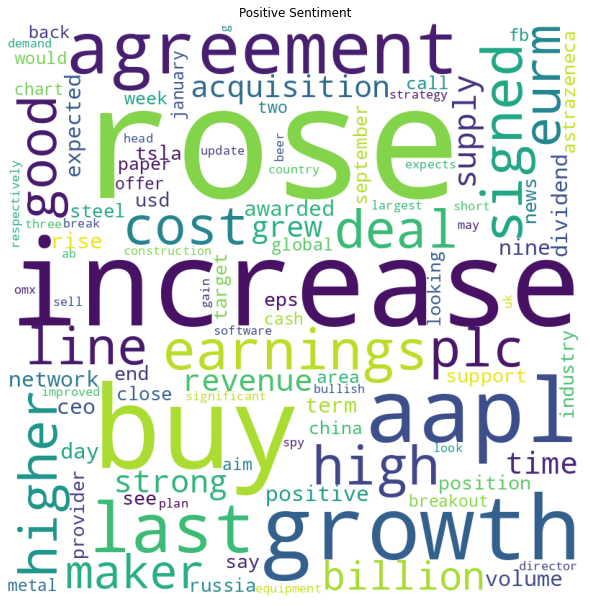

In [ ]:
#word cloud for positive word sentiment after removing top 75 words
wc_pos_words = Counter(pos_words)
wordcloud = WordCloud(width=800, height=800, background_color='white', max_words=100).generate_from_frequencies(wc_pos_words)
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.title('Positive Sentiment')
plt.show()

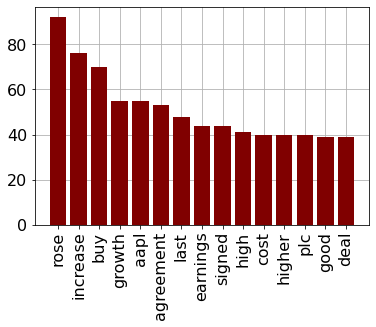

In [ ]:
#bar graphs as per word and word count for Positive sentiments
tokens_pos = [word_tokenize(review) for review in pos_words]
pos_tokens = [[word for word in item if len(word) > 2] for item in tokens_pos]
last_token = list(itertools.chain(*pos_tokens)) 
bow_pos = Counter(last_token).most_common(15) ### Displays the 15 most common words in pos articles of the dataset.
labels = [item[0] for item in bow_pos]
number = [item[1] for item in bow_pos]
nbars = len(bow_pos)

plt.grid(zorder=0)
plt.bar(np.arange(nbars), number, tick_label=labels,color ='maroon',zorder=3)
plt.xticks(rotation=90,fontsize=16)
plt.yticks(fontsize=16)
plt.show()

**For Negative words**

In [ ]:
#Displays the 15 most common words in pos articles of the dataset.
tokens_neg = [word_tokenize(review) for review in neg_words]
neg_tokens = [[word for word in item if len(word) > 2] for item in tokens_neg]
last_token = list(itertools.chain(*neg_tokens)) 
bow_neg = Counter(last_token).most_common(15)
bow_neg

[('short', 47),
 ('fell', 44),
 ('lower', 43),
 ('tsla', 34),
 ('half', 33),
 ('fall', 28),
 ('aapl', 27),
 ('totalled', 26),
 ('cut', 24),
 ('omx', 23),
 ('spy', 21),
 ('day', 21),
 ('model', 19),
 ('recall', 19),
 ('cost', 19)]

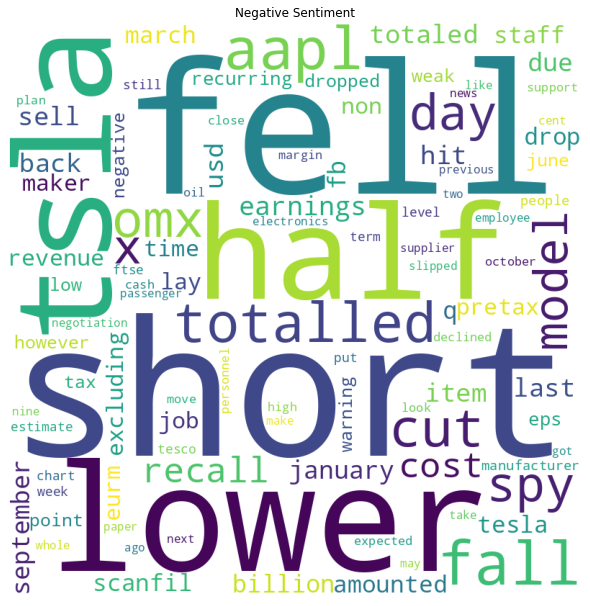

In [ ]:
#word cloud for negative word sentiment after removing top 75 words
wc_neg_words = Counter(neg_words)
wordcloud = WordCloud(width=800, height=800, background_color='white', max_words=100).generate_from_frequencies(wc_neg_words)
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.title('Negative Sentiment')
plt.show()

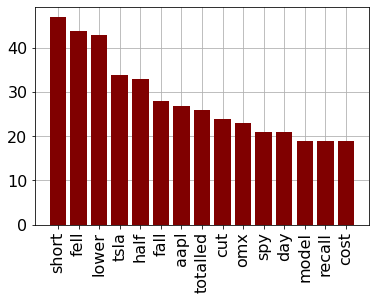

In [ ]:
#bar graphs after removing top 75 words as per word and word count for Negative Sentiment
tokens_neg = [word_tokenize(review) for review in neg_words]
neg_tokens = [[word for word in item if len(word) > 2] for item in tokens_neg]
last_token = list(itertools.chain(*neg_tokens)) 
bow_neg = Counter(last_token).most_common(15) ### Displays the 15 most common words in neg articles of the dataset.
labels = [item[0] for item in bow_neg]
number = [item[1] for item in bow_neg]
nbars = len(bow_neg)

plt.grid(zorder=0)
plt.bar(np.arange(nbars), number, tick_label=labels,color ='maroon',zorder=3)
plt.xticks(rotation=90,fontsize=16)
plt.yticks(fontsize=16)
plt.show()

**For Neutral words**

In [ ]:
#Displays the 15 most common words in pos articles of the dataset.
tokens_neu = [word_tokenize(review) for review in neu_words]
neu_tokens = [[word for word in item if len(word) > 2] for item in tokens_neu]
last_token = list(itertools.chain(*neu_tokens)) 
bow_neu = Counter(last_token).most_common(15)
bow_neu

[('part', 81),
 ('board', 79),
 ('building', 75),
 ('construction', 69),
 ('industry', 68),
 ('development', 67),
 ('area', 66),
 ('medium', 66),
 ('january', 66),
 ('would', 62),
 ('employee', 62),
 ('approximately', 62),
 ('end', 60),
 ('right', 58),
 ('omx', 58)]

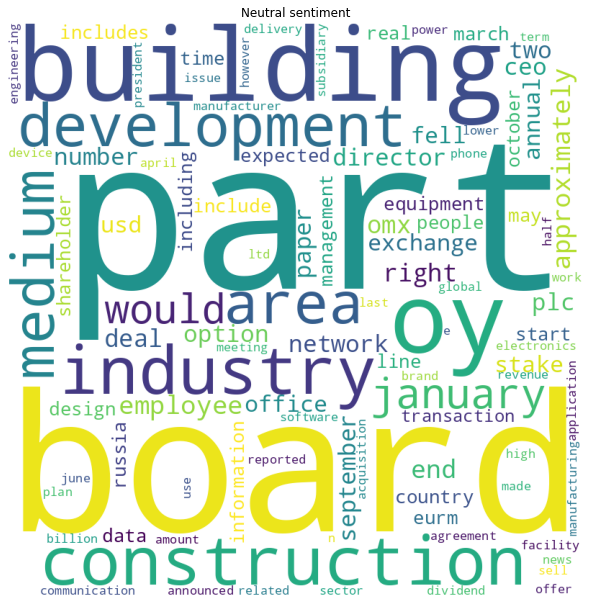

In [ ]:
#word cloud for neutral word sentiment after removing top 75 words
wc_neu_words = Counter(neu_words)
wordcloud = WordCloud(width=800, height=800, background_color='white', max_words=100).generate_from_frequencies(wc_neu_words)
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.title('Neutral sentiment')
plt.show()

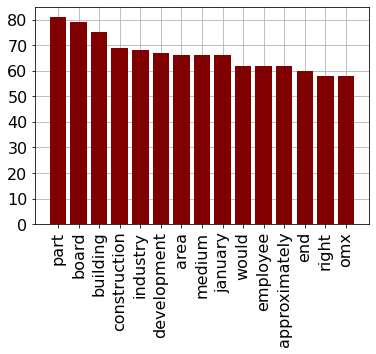

In [ ]:
#bar graphs after removing top 75 words as per word and word count for Neutral Sentiment
tokens_neu = [word_tokenize(review) for review in neu_words]
neu_tokens = [[word for word in item if len(word) > 2] for item in tokens_neu]
last_token = list(itertools.chain(*neu_tokens)) 
bow_neu = Counter(last_token).most_common(15) ### Displays the 15 most common words in neu articles of the dataset.
labels = [item[0] for item in bow_neu]
number = [item[1] for item in bow_neu]
nbars = len(bow_neu)

plt.grid(zorder=0)
plt.bar(np.arange(nbars), number, tick_label=labels,color ='maroon',zorder=3)
plt.xticks(rotation=90,fontsize=16)
plt.yticks(fontsize=16)
plt.show()

All Sentiments 

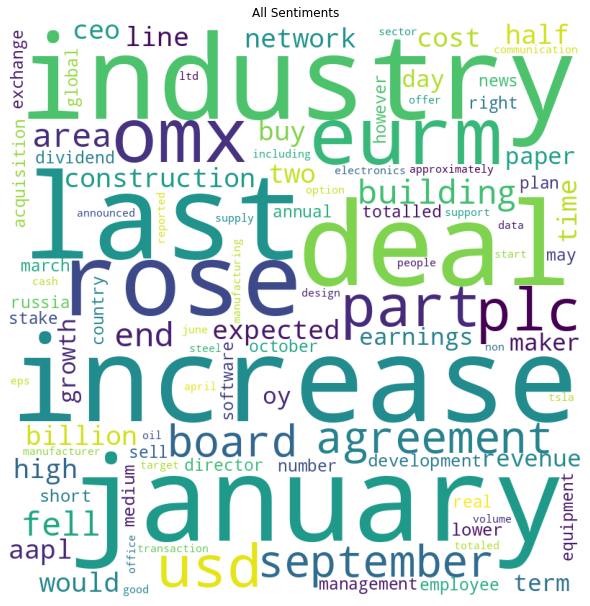

In [ ]:
#word cloud for All word sentiment after removing top 75 words

wc_all_words = Counter(all_words)
wordcloud = WordCloud(width=800, height=800, background_color='white', max_words=100).generate_from_frequencies(wc_all_words)
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.title('All Sentiments')
plt.show()

In [ ]:
#Displays the 15 most common words in all sentiments of the dataset.
tokens_all = [word_tokenize(review) for review in all_words]
all_tokens = [[word for word in item if len(word) > 2] for item in tokens_all]
last_token = list(itertools.chain(*all_tokens)) 
bow_all = Counter(last_token).most_common(15)
bow_all

[('increase', 106),
 ('last', 105),
 ('january', 105),
 ('industry', 103),
 ('deal', 102),
 ('rose', 101),
 ('eurm', 100),
 ('omx', 100),
 ('part', 100),
 ('usd', 99),
 ('plc', 99),
 ('agreement', 98),
 ('september', 98),
 ('board', 96),
 ('building', 96)]

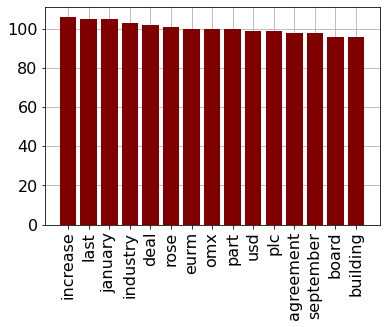

In [ ]:
#bar graphs after removing top 75 words as per word and word count for All Sentiment

tokens_all = [word_tokenize(review) for review in all_words]
all_tokens = [[word for word in item if len(word) > 2] for item in tokens_all]
last_token = list(itertools.chain(*all_tokens)) 
bow_all = Counter(last_token).most_common(15)
labels = [item[0] for item in bow_all]
number = [item[1] for item in bow_all]
nbars = len(bow_all)

plt.grid(zorder=0)
plt.bar(np.arange(nbars), number, tick_label=labels,color ='maroon',zorder=3)
plt.xticks(rotation=90,fontsize=16)
plt.yticks(fontsize=16)
plt.show()

In [ ]:
uni_pos = set(pos_words)
print('Type of Unique Positive Words', type(uni_pos))
print('Length of Unique Positive Words', len(uni_pos))
print('\n')

uni_neg = set(neg_words)
print('Type of Unique Negative Words', type(neg_words))
print('Length of Unique Negative Words', len(neg_words))
print('\n')

uni_neu = set(neu_words)
print('Type of Unique Neutral Words', type(neu_words))
print('Length of Unique Neutral Words', len(neu_words))

Type of Unique Positive Words <class 'set'>
Length of Unique Positive Words 4775


Type of Unique Negative Words <class 'list'>
Length of Unique Negative Words 6146


Type of Unique Neutral Words <class 'list'>
Length of Unique Neutral Words 27408


In [ ]:
df.head(5)

Sentence Sentiment
0  geosolutions technology leverage benefon gps s...  positive
1                        esi low bk real possibility  negative
2  last quarter componenta net sale doubled eurm ...  positive
3  according finnish russian chamber commerce maj...   neutral
4  swedish buyout firm sold remaining percent sta...   neutral

**After removing top 75 words**

In [ ]:
############################################################################
def remove_words_not_in_set(sentence, word_set):
    # Split sentence into list of words
    words = sentence.split()
    # Filter out words not in set
    filtered_words = [word for word in words if word in word_set]
    # Join filtered words back into a sentence
    filtered_sentence = ' '.join(filtered_words)
    return filtered_sentence

In [ ]:
# Apply function to each sentence in data
filtered_sentences = []
for sentence, sentiment in zip(df['Sentence'], df['Sentiment']):
    if sentiment == 'positive':
        filtered_sentence = remove_words_not_in_set(sentence, pos_words)# any dupicates found change this pos_words = uni_pos
    elif sentiment == 'negative':
        filtered_sentence = remove_words_not_in_set(sentence, neg_words)
    else:
        filtered_sentence = remove_words_not_in_set(sentence, neu_words)
    filtered_sentences.append(filtered_sentence)

In [ ]:
#creating the a new column for the filtered sentences
df['Filtered_Sentence'] = filtered_sentences

df.head()

Sentence Sentiment  \
0  geosolutions technology leverage benefon gps s...  positive   
1                        esi low bk real possibility  negative   
2  last quarter componenta net sale doubled eurm ...  positive   
3  according finnish russian chamber commerce maj...   neutral   
4  swedish buyout firm sold remaining percent sta...   neutral   

                                   Filtered_Sentence  
0  geosolutions leverage benefon gps providing lo...  
1                        esi low bk real possibility  
2  last componenta doubled eurm eurm moved zero p...  
3  russian chamber commerce major construction ru...  
4  swedish buyout firm sold remaining stake almos...

In [ ]:
df_2 = df[['Filtered_Sentence', "Sentiment"]]
df_2

Filtered_Sentence Sentiment
0     geosolutions leverage benefon gps providing lo...  positive
1                           esi low bk real possibility  negative
2     last componenta doubled eurm eurm moved zero p...  positive
3     russian chamber commerce major construction ru...   neutral
4     swedish buyout firm sold remaining stake almos...   neutral
...                                                 ...       ...
5837  rising cost forced packaging producer huhtamak...  negative
5838  nordic walking used summer training method cro...   neutral
5839  shipping viking line eu decision significant i...   neutral
5840                    building home improvement trade   neutral
5841  afx kci konecranes four hot metal ladle crane ...  positive

[5842 rows x 2 columns]

In [ ]:
df_2 = df.drop_duplicates(subset=['Sentence'], keep=False)
df_2

Sentence Sentiment  \
0     geosolutions technology leverage benefon gps s...  positive   
1                           esi low bk real possibility  negative   
2     last quarter componenta net sale doubled eurm ...  positive   
3     according finnish russian chamber commerce maj...   neutral   
4     swedish buyout firm sold remaining percent sta...   neutral   
...                                                 ...       ...   
5835       hsbc say unit book million charge settlement  negative   
5836  daily mail parent company talk potential partn...  positive   
5838  nordic walking first used summer training meth...   neutral   
5839  according shipping company viking line eu deci...   neutral   
5841  helsinki afx kci konecranes said order four ho...  positive   

                                      Filtered_Sentence  
0     geosolutions leverage benefon gps providing lo...  
1                           esi low bk real possibility  
2     last componenta doubled eurm eurm moved zero p...  
3     russian chamber commerce major construction ru...  
4     swedish buyout firm sold remaining stake almos...  
...                                                 ...  
5835                    hsbc say book charge settlement  
5836  daily mail parent talk potential partner joint...  
5838  nordic walking used summer training method cro...  
5839  shipping viking line eu decision significant i...  
5841  afx kci konecranes four hot metal ladle crane ...  

[4706 rows x 3 columns]

In [ ]:
df_2

Sentence Sentiment  \
0     geosolutions technology leverage benefon gps s...  positive   
1                           esi low bk real possibility  negative   
2     last quarter componenta net sale doubled eurm ...  positive   
3     according finnish russian chamber commerce maj...   neutral   
4     swedish buyout firm sold remaining percent sta...   neutral   
...                                                 ...       ...   
5835       hsbc say unit book million charge settlement  negative   
5836  daily mail parent company talk potential partn...  positive   
5838  nordic walking first used summer training meth...   neutral   
5839  according shipping company viking line eu deci...   neutral   
5841  helsinki afx kci konecranes said order four ho...  positive   

                                      Filtered_Sentence  
0     geosolutions leverage benefon gps providing lo...  
1                           esi low bk real possibility  
2     last componenta doubled eurm eurm moved zero p...  
3     russian chamber commerce major construction ru...  
4     swedish buyout firm sold remaining stake almos...  
...                                                 ...  
5835                    hsbc say book charge settlement  
5836  daily mail parent talk potential partner joint...  
5838  nordic walking used summer training method cro...  
5839  shipping viking line eu decision significant i...  
5841  afx kci konecranes four hot metal ladle crane ...  

[4706 rows x 3 columns]